## 자료 수집

##### 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### 부도 기업 뽑기
`대상` : 코스닥  
`기간` : 2000~2017  
`부도 정의` : 부도발생, 화의절차개시신청, 회사정리절차,개시신청, 감사인의 의견 거절, 은행거래 정지--> 자본전액잠식, 감사의견 부적정 추가   
[`추가논의사항`](http://listing.krx.co.kr/contents/LST/04/04020500/LST04020500.jsp)
> **상장폐지현황.xlsx** : KIND에서 뽑은 해당 기간 상장폐지기업 데이터

In [2]:
ksd = pd.read_excel('../Data/상장폐지현황.xlsx',engine='openpyxl')
ksd = ksd.sort_values('번호')

# 상장폐지사유에서 부도 정의 기업 뽑기 
default = ksd[ksd['폐지사유'].str.contains('부도')]
composition =ksd[ksd['폐지사유'].str.contains('화의절차개시신청')]
disclaimer = ksd[ksd['폐지사유'].str.contains('감사의견거절')]
disclaimer_2 = ksd[ksd['폐지사유'].str.contains('의견 거절')]
suspension = ksd[ksd['폐지사유'].str.contains('은행거래정지')]	
liquidation = ksd[ksd['폐지사유'].str.contains('회사정리절차')]
afc = ksd[ksd['폐지사유'].str.contains('개시신청')]#Application for commencement
erosion = ksd[ksd['폐지사유'].str.contains('전액잠식')] #완전잠식기업 
adverse_opinion = ksd[ksd['폐지사유'].str.contains('부적정')] #감사의견 부적정 

# outer join 으로 중복되는 경우 없이 뽑기 
ksd_default = pd.merge(default, composition,how='outer')
ksd_default = pd.merge(ksd_default,disclaimer,how='outer')
ksd_default = pd.merge(ksd_default,suspension,how='outer')
ksd_default = pd.merge(ksd_default,disclaimer_2,how='outer')
ksd_default = pd.merge(ksd_default,liquidation,how='outer')
ksd_default = pd.merge(ksd_default,afc,how='outer')
ksd_default = pd.merge(ksd_default,erosion,how='outer')
ksd_default = pd.merge(ksd_default,adverse_opinion,how='outer')



ksd_default.set_index('번호',inplace=True)
ksd_default.reset_index(drop=True,inplace=True)

ksd_default.sort_values('폐지일자')

#필터링 한 코드 저장
# ksd_default.to_csv('../Data/ksd_default.csv',index=False,encoding='cp949') 
# 부도 정의 개념 넓힌 결과 194개에서 261개로 부도기업 수 증가

,회사명,종목코드,폐지일자,폐지사유,비고
0,라인건설,17620,2000-06-07,"최종부도 또는 당좌거래정지(1년) , 기타 등록취소",NaN
194,삼주건설,25150,2000-06-07,"주식분산기준미달 , 자본전액잠식(2년)",NaN
200,삼경정밀,13320,2000-06-07,자본전액잠식(2년),NaN
199,동양기공,18720,2000-06-07,"자본전액잠식(2년) , 기타 등록취소",NaN
198,금강정공,22770,2000-06-07,"자본전액잠식(2년) , 기타 등록취소",NaN
...,...,...,...,...,...
189,아이팩토리,53810,2016-09-19,감사의견 거절(감사범위 제한 및 기업회계기준 위배),NaN
253,우전,52270,2017-04-13,자본전액잠식 등,NaN
190,신양오라컴,86830,2017-05-08,감사의견 거절(감사범위 제한 및 계속기업 존속능력에 대한 불확실성),NaN
191,에스에스컴텍,36500,2017-05-11,감사의견 거절(감사범위 제한 및 계속기업 존속능력에 대한 불확실성),NaN


### 전체 기업 데이터
> **ksd_default.csv** : 부도 정의에 부합하는 상장폐지 기업들   
  **origin_raw.xlsx** : ts2000 수집기간 코스닥 전체 기업의 재무변수 데이터_ 부도 기업에 대해서는 결측치 Dart에서 찾아서 채워둠


In [3]:
ksd_default = pd.read_csv('../Data/ksd_default.csv',encoding='cp949') #위에서 저장한 부도 기업 불러오기 
RAW = pd.read_excel('../Data/origin_raw.xlsx',engine='openpyxl') #재무변동성 코드 추가 전, ts2000 + DART 직접 기입 한 자료 
RAW = RAW.sort_values(by=['회사명','회계년도'],ascending=[True,True])
RAW.reset_index(drop=True,inplace=True)

### 변수 생성

In [4]:
#변수생성
RAW['현금순환주기'] = RAW['재고자산회전기간'] + RAW['매출채권회전기간'] - RAW['매입채무회전기간']
RAW['WCTA'] = RAW['유동자산'] / RAW['자산']
RAW['RETA'] = RAW['이익잉여금'] / RAW['자산']
RAW['TLTA'] = RAW['부채'] /RAW['자산']
RAW['이자보상배율'] = RAW['영업이익(손실)']/RAW['이자비용']

#재무상태변동성 변수 만들기
volatility = ["회사명", '유동비율','매출액증가율','유형자산증가율','총자본증가율','매출액총이익률',
             '매출액영업이익률','자기자본순이익률','총자본영업이익률','당좌비율','부채비율',
             '이자보상배율','재고자산회전률','매출채권회전률','총자본회전률','매입채무회전률']
RAW_1 = RAW[volatility]
names = RAW_1["회사명"].unique()
subset = []
for name in names :
    k = RAW_1.loc[RAW_1["회사명"] == name].iloc[:,1:]
    a = (k - k.shift(1)).fillna(0)
    subset.append(a)
col_new = pd.concat(subset)
for i in col_new :
    col_new.rename(columns={i:f"vol{i}"}, inplace=True)
# col_new
RAW_2= pd.concat([RAW,col_new],axis=1)

### 부도기업 라벨링
1. **RAW_2**     
    부도 직전 년도 라벨 : 1    
    부도 직전전 년도 라벨 : 0.5      
2. **RAW_3**   
    부도 라벨 0.5 빼기 


In [5]:
default_label = ksd_default['종목코드'].tolist()

RAW_2['부도'] = 0

a = RAW_2[RAW_2['거래소코드'].isin(default_label)]
company=a['회사명'].unique() #부도기업 고유이름 

lst = [] #부도만 담을 빈 리스트 생성
lst2 = [] # 그레이존만 담은 빈 리스트 생성
for i in range(len(company)):
    lst.append((RAW_2[RAW_2['회사명']== company[i]]['부도'].index[-1]))
    if int(len(RAW_2[RAW_2['회사명']== company[i]])>1):    
        lst2.append((RAW_2[RAW_2['회사명']== company[i]]['부도'].index[-2]))
    #회사명이 부도인 애들만 골라서, 그중 맨 최근컬럼을 빈 리스트에 append 
    
for i in range(len(lst)):
    RAW_2.loc[lst[i],'부도'] = 1
    
for i in range(len(lst2)):    
    RAW_2.loc[lst2[i],'부도'] = 0.5
    #부도기업 리스트인 것에 1값 부여 
# RAW_2

In [204]:
RAW_3 = RAW_2[(RAW_2['부도'] !=0.5)]
default = RAW_3[RAW_3['부도']==1]
default.loc[(default.유동비율.isna())|(default.자산.isna())]

In [209]:
# drop =['매입채무회전기간','재고자산회전기간','매출채권회전기간', '영업이익(손실)', '자산', '부채', '유동자산', '이익잉여금', '이자비용']
# RAW_2.drop(drop,axis=1,inplace=True)
# # RAW_2.to_csv('../Data/origin_labeled.csv',index= False, encoding='cp949')

In [ ]:
drop =['매입채무회전기간','재고자산회전기간','매출채권회전기간', '영업이익(손실)', '자산', '부채', '유동자산', '이익잉여금', '이자비용']
RAW_3.drop(drop,axis=1,inplace=True)
# RAW_3.to_csv('../Data/origin_labeled.csv',index= False, encoding='cp949')

## 전처리

### 라이브러리 

In [6]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

#맥 폰트 
# from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

#윈도우 폰트 
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

### 국면분할  
**확장** : 2002 ,2006, 2007, 2010, 2014, 2015, 2016     
**수축** : 2003, 2004, 2008, 2009, 2012     
**전환** : 2000, 2001, 2005, 2011, 2013, 2017  

<img width="930" alt="화면 캡처 2022-07-11 150527" src="https://user-images.githubusercontent.com/99321739/178199192-8eae3896-1d32-483a-a0cc-b738e7e2fe82.png">


In [7]:
RAW = pd.read_csv('../Data/origin_labeled.csv',encoding='cp949')
RAW['회계년도']=RAW['회계년도'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
RAW.iloc[:,2]=RAW['회계년도'].dt.strftime('%Y')
# RAW


#정상기업 데이터 내 부도 기업 코드 행 추출하기 위한 리스트 생성
ksd = pd.read_csv('../Data/ksd_default.csv',encoding='cp949')

In [10]:
RAW.columns

Index(['회사명', '거래소코드', '회계년도', '유동비율', '차입금의존도', '매출액증가율', '유형자산증가율', '총자본증가율',
       '매출액총이익률', '매출액영업이익률', '매출액순이익률', '총자본영업이익률', '자기자본순이익률', '당좌비율',
       '부채비율', '재고자산회전률', '매출채권회전률', '총자본회전률', '매입채무회전률', '현금순환주기', 'WCTA',
       'RETA', 'TLTA', '이자보상배율', 'vol유동비율', 'vol매출액증가율', 'vol유형자산증가율',
       'vol총자본증가율', 'vol매출액총이익률', 'vol매출액영업이익률', 'vol자기자본순이익률', 'vol총자본영업이익률',
       'vol당좌비율', 'vol부채비율', 'vol이자보상배율', 'vol재고자산회전률', 'vol매출채권회전률',
       'vol총자본회전률', 'vol매입채무회전률', '부도'],
      dtype='object')

#### 확장기

In [214]:
# 확장기 년도로 뽑기 
expansion_y =map(str,[2002,2006,2007,2010,2014,2015,2016])
expansion = RAW[RAW['회계년도'].isin(expansion_y)]
# expansion = expansion.dropna(axis=0)

#정상기업
expansion_normal = expansion[expansion['부도']==0]
expansion_normal.reset_index(drop=True,inplace=True)

#부도기업
expansion_default = expansion[expansion['부도']==1]
expansion_default.reset_index(drop=True,inplace=True)


확장기 기업 수 확인

In [216]:
# 2002
norm_02 = expansion_normal[expansion_normal['회계년도']=='2002']
default_02 = expansion_default[expansion_default['회계년도']=='2002']

# 2006
norm_06 = expansion_normal[expansion_normal['회계년도']=='2006']
default_06 = expansion_default[expansion_default['회계년도']=='2006']

# '2007'
norm_07 = expansion_normal[expansion_normal['회계년도']=='2007']
default_07 = expansion_default[expansion_default['회계년도']=='2007']

# '2010'
norm_10 = expansion_normal[expansion_normal['회계년도']=='2010']
default_10 = expansion_default[expansion_default['회계년도']=='2010']

#'2014'
norm_14 = expansion_normal[expansion_normal['회계년도']=='2014']
default_14 = expansion_default[expansion_default['회계년도']=='2014']

#'2015'
norm_15 = expansion_normal[expansion_normal['회계년도']=='2015']
default_15 = expansion_default[expansion_default['회계년도']=='2015']

# '2016'
norm_16 = expansion_normal[expansion_normal['회계년도']=='2016']
default_16 = expansion_default[expansion_default['회계년도']=='2016']

ex =pd.DataFrame({'정상':[norm_02.shape[0],norm_06.shape[0],norm_07.shape[0],norm_10.shape[0],norm_14.shape[0],norm_15.shape[0],norm_16.shape[0]],
              '부도':[default_02.shape[0],default_06.shape[0],default_07.shape[0],default_10.shape[0],default_14.shape[0],default_15.shape[0],default_16.shape[0]]},
             index=[2002,2006,2007,2010,2014,2015,2016])

#### 수축기 

In [217]:
# 수축기 년도로 뽑기 
recession_y =map(str,[2003,2004,2008,2009,2012])
recession = RAW[RAW['회계년도'].isin(recession_y)]
# recession = recession.dropna(axis=0)

#정상기업
recession_normal = recession[recession['부도']==0]
recession_normal.reset_index(drop=True,inplace=True)

#부도기업
recession_default = recession[recession['부도']==1]
recession_default.reset_index(drop=True,inplace=True)

수축기 기업 수 확인

In [218]:
# 2003
norm_03 = recession_normal[recession_normal['회계년도']=='2003']
default_03 = recession_default[recession_default['회계년도']=='2003']

# 2004
norm_04 = recession_normal[recession_normal['회계년도']=='2004']
default_04 = recession_default[recession_default['회계년도']=='2004']

# '2008'
norm_08 = recession_normal[recession_normal['회계년도']=='2008']
default_08 = recession_default[recession_default['회계년도']=='2008']

# '2009'
norm_09 = recession_normal[recession_normal['회계년도']=='2009']
default_09 = recession_default[recession_default['회계년도']=='2009']

#'2012'
norm_12 = recession_normal[recession_normal['회계년도']=='2012']
default_12 = recession_default[recession_default['회계년도']=='2012']


rc = pd.DataFrame({'정상':[norm_03.shape[0],norm_04.shape[0],norm_08.shape[0],norm_09.shape[0],norm_12.shape[0]],
              '부도':[default_03.shape[0],default_04.shape[0],default_08.shape[0],default_09.shape[0],default_12.shape[0]]},
             index=[2003,2004,2008,2009,2012])

#### 전환기

In [219]:
# 전환기 년도로 뽑기 
transition_y =map(str,[2000,2001,2005,2011,2013,2017])
transition = RAW[RAW['회계년도'].isin(transition_y)]
# transition = transition.dropna(axis=0)

#정상기업
transition_normal = transition[transition['부도']==0]
transition_normal.reset_index(drop=True,inplace=True)

#부도기업
transition_default = transition[transition['부도']==1]
transition_default.reset_index(drop=True,inplace=True)


전환기별 기업 수 확인

In [220]:
# 2000
norm_00 = transition_normal[transition_normal['회계년도']=='2000']
default_00 = transition_default[transition_default['회계년도']=='2000']

#2001
norm_01 = transition_normal[transition_normal['회계년도']=='2001']
default_01 = transition_default[transition_default['회계년도']=='2001']

# 2005
norm_05 = transition_normal[transition_normal['회계년도']=='2005']
default_05 = transition_default[transition_default['회계년도']=='2005']

# '2011'
norm_11 = transition_normal[transition_normal['회계년도']=='2011']
default_11 = transition_default[transition_default['회계년도']=='2011']

# '2013'
norm_13 = transition_normal[transition_normal['회계년도']=='2013']
default_13 = transition_default[transition_default['회계년도']=='2013']

#'2017'
norm_17 = transition_normal[transition_normal['회계년도']=='2017']
default_17 = transition_default[transition_default['회계년도']=='2017']


tran = pd.DataFrame({'정상':[norm_00.shape[0],norm_01.shape[0],norm_05.shape[0],norm_11.shape[0],norm_13.shape[0],norm_17.shape[0]],
              '부도':[default_00.shape[0],default_01.shape[0],default_05.shape[0],default_11.shape[0],default_13.shape[0],default_17.shape[0]]},
             index=[2000,2001,2005,2011,2013,2017])

#### 시각화

In [221]:
all = pd.concat([ex,rc,tran],axis=0)
all =all.sort_index()
all = all.reset_index()

ex_1 = ex.T
ex_1['합'] = ex_1.sum(axis=1)
# ex_1.to_csv('../Data/확장기_기업수.csv',encoding='cp949')

rc_1 = rc.T
rc_1['합'] = rc_1.sum(axis=1)
# rc_1.to_csv('../Data/수축기_기업수.csv',encoding='cp949')

tran_1 = tran.T
tran_1['합'] = tran_1.sum(axis=1)
# tran_1.to_csv('../Data/전환기_기업수.csv',encoding='cp949')

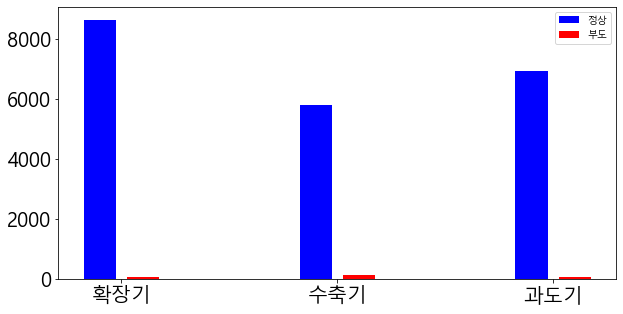

In [225]:
cycle = pd.DataFrame({'정상':[ex['정상'].sum(),rc['정상'].sum(),tran['정상'].sum()],
              '부도':[ex['부도'].sum(),rc['부도'].sum(),tran['부도'].sum()]},
             index=['확장기','수축기','과도기'])

w = 0.1
nrow =cycle.shape[0]
idx = np.arange(nrow)
idx

plt.figure(figsize=(10,5))
plt.bar(idx-w,cycle['정상'],label = '정상',color ='blue',width=0.15)
plt.bar(idx+w,cycle['부도'],label = '부도',color='red',width=0.15)
plt.xticks(idx,cycle.index)

plt.legend()
plt.show()

In [226]:
all.set_index('index').T

index,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
정상,905,1003,1070,1066,1119,1162,1205,1265,1238,1201,1188,1184,1188,1221,1251,1309,1346,1467
부도,2,8,14,31,22,2,6,10,35,28,26,17,13,12,7,6,4,6


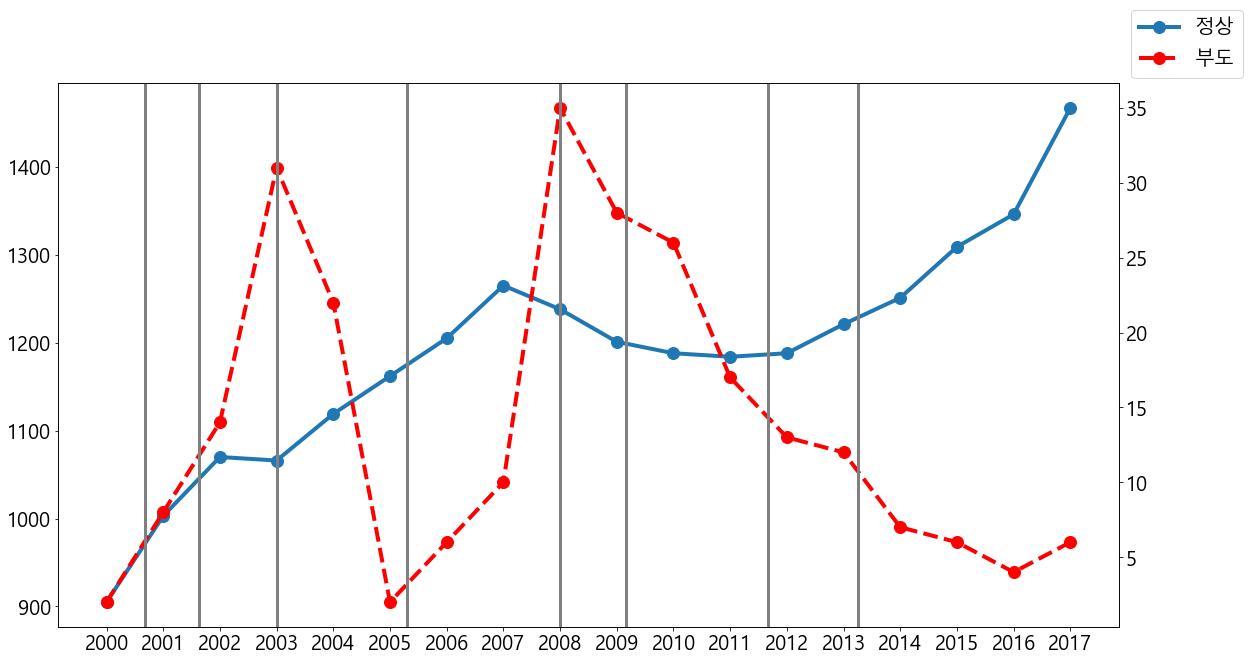

In [227]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(parameters)
ax = all.plot(x='index', y="정상", xlabel='',legend=False,figsize=(19,10),linewidth='4',marker='o',markersize='12')
ax2 = ax.twinx()
all.plot(x='index', y="부도", ax=ax2, legend=False, color="r",linestyle = '--',linewidth='4',marker='o',markersize='12')
# plt.rcParams['font.family'] ='Malgun Gothic'
plt.xticks(all['index'])
# plt.title('국면별 기업 데이터 수')
ax.figure.legend(fontsize=20)
plt.axvline(x=2000.67,color='gray',linewidth='3')
plt.axvline(x=2001.63,color='gray',linewidth='3')
plt.axvline(x=2003,color='gray',linewidth='3')
plt.axvline(x=2005.3,color='gray',linewidth='3')
plt.axvline(x=2008,color='gray',linewidth='3')
plt.axvline(x=2009.17,color='gray',linewidth='3')
plt.axvline(x=2011.67,color='gray',linewidth='3')
plt.axvline(x=2013.25,color='gray',linewidth='3')
# plt.axvline(x=2017.75,color='gray')


plt.show()

#### 국면별 기업 수 최종 확인

In [228]:
print('##### 확장기')
print(f'정상 기업 수 : {len(expansion_normal["회사명"].unique())}')
print(f'부도 기업 수 : {len(expansion_default["회사명"].unique())}')
print('##### 수축기')
print(f'정상 기업 수 : {len(recession_normal["회사명"].unique())}')
print(f'부도 기업 수 : {len(recession_default["회사명"].unique())}')
print('##### 과도기')
print(f'정상 기업 수 : {len(transition_normal["회사명"].unique())}')
print(f'부도 기업 수 : {len(transition_default["회사명"].unique())}')

##### 확장기
정상 기업 수 : 1778
부도 기업 수 : 73
##### 수축기
정상 기업 수 : 1525
부도 기업 수 : 129
##### 과도기
정상 기업 수 : 1964
부도 기업 수 : 47


### 결측치

In [229]:
normal_lst=[expansion_normal,recession_normal,transition_normal]
default_lst=[expansion_default,recession_default,transition_default]
name_lst = ['expansion','recession','transition']
print('--국면별 정상기업 결측치--')
for i in range(len(normal_lst)):
    print(name_lst[i],':',normal_lst[i].isna().sum().max())
print()
print('--국면별 부도기업 결측치--')
for i in range(len(default_lst)):
    print(name_lst[i],':',default_lst[i].isna().sum().max())


--국면별 정상기업 결측치--
expansion : 555
recession : 212
transition : 652

--국면별 부도기업 결측치--
expansion : 7
recession : 0
transition : 7


In [230]:
for i in normal_lst:
    i.dropna(axis=0,inplace=True)
    
for j in default_lst:
    j.dropna(axis=0,inplace=True)
    
print('--국면별 정상기업 결측치--')
for i in range(len(normal_lst)):
    print(name_lst[i],':',normal_lst[i].isna().sum().max())
print()
print('--국면별 부도기업 결측치--')
for i in range(len(default_lst)):
    print(name_lst[i],':',default_lst[i].isna().sum().max())

--국면별 정상기업 결측치--
expansion : 0
recession : 0
transition : 0

--국면별 부도기업 결측치--
expansion : 0
recession : 0
transition : 0


### 이상치

#### winsorizing
1.inf 값 제거

In [231]:
#국면별 inf 값 제거
for i in range(len(normal_lst)):
    normal_lst[i] = normal_lst[i].replace([np.inf, -np.inf], np.nan)
for j in range(len(default_lst)):
    default_lst[j] = default_lst[j].replace([np.inf, -np.inf], np.nan)
print('--국면별 정상기업 inf 값--')
for i in range(len(normal_lst)):
    print(name_lst[i],':',normal_lst[i].isin([-np.inf,np.inf]).sum().max())
print()
print('--국면별 부도기업 inf 값--')
for i in range(len(default_lst)):
    print(name_lst[i],':',default_lst[i].isin([-np.inf,np.inf]).sum().max())
#inf -> nall 결측치 국면별 제거
for i in range(len(normal_lst)):
    normal_lst[i]= normal_lst[i].dropna(axis=0)
for j in range(len(default_lst)):
    default_lst[j] = default_lst[j].dropna(axis=0)
    
expansion_normal=normal_lst[0]
recession_normal=normal_lst[1]
transition_normal=normal_lst[2]

expansion_default =  default_lst[0]
recession_default = default_lst[1]
transition_default = default_lst[2]

--국면별 정상기업 inf 값--
expansion : 0
recession : 0
transition : 0

--국면별 부도기업 inf 값--
expansion : 0
recession : 0
transition : 0


In [232]:
# expansion_normal.to_csv('../Data/NA/expansion_normal.csv',index=False,encoding='cp949')
# expansion_default.to_csv('../Data/NA/expansion_default.csv',index=False,encoding='cp949')
# recession_normal.to_csv('../Data/NA/recession_normal.csv',index=False,encoding='cp949')
# recession_default.to_csv('../Data/NA/recession_default.csv',index=False,encoding='cp949')
# transition_normal.to_csv('../Data/NA/transition_normal.csv',index=False,encoding='cp949')
# transition_default.to_csv('../Data/NA/transition_default.csv',index=False,encoding='cp949')

#### Winsorizing

In [233]:
expansion_normal = pd.read_csv('../Data/NA/expansion_normal.csv',encoding='cp949')
expansion_default = pd.read_csv('../Data/NA/expansion_default.csv',encoding='cp949')

recession_normal = pd.read_csv('../Data/NA/recession_normal.csv',encoding='cp949')
recession_default = pd.read_csv('../Data/NA/recession_default.csv',encoding='cp949')

transition_normal = pd.read_csv('../Data/NA/transition_normal.csv',encoding='cp949')
transition_default = pd.read_csv('../Data/NA/transition_default.csv',encoding='cp949')

In [238]:
from scipy.stats.mstats import winsorize

drop = ['회사명','거래소코드', '회계년도','부도']
recession_normal_win = recession_normal.drop(drop,axis=1)
for col in recession_normal_win.columns:
    recession_normal_win[col] = winsorize(recession_normal_win[col], limits=[0.05, 0.05]) #0.5 값에 대해 윈저라이징 
    
recession_default_win = recession_default.drop(drop,axis=1)
for col in recession_default_win.columns:
    recession_default_win[col] = winsorize(recession_default_win[col], limits=[0.05, 0.05]) #0.5 값에 대해 윈저라이징 
    
expansion_normal_win = expansion_normal.drop(drop,axis=1)
for col in expansion_normal_win.columns:
    expansion_normal_win[col] = winsorize(expansion_normal_win[col], limits=[0.05, 0.05]) #0.5 값에 대해 윈저라이징 
    
expansion_default_win = expansion_default.drop(drop,axis=1)
for col in expansion_default_win.columns:
    expansion_default_win[col] = winsorize(expansion_default_win[col], limits=[0.05, 0.05]) #0.5 값에 대해 윈저라이징 
    
transition_normal_win = transition_normal.drop(drop,axis=1)
for col in transition_normal_win.columns:
    transition_normal_win[col] = winsorize(transition_normal_win[col], limits=[0.05, 0.05]) #0.5 값에 대해 윈저라이징 
    
transition_default_win = transition_default.drop(drop,axis=1)
for col in transition_default_win.columns:
    transition_default_win[col] = winsorize(transition_default_win[col], limits=[0.05, 0.05]) #0.5 값에 대해 윈저라이징 
    


In [239]:
recession_normal.iloc[:,3:-1] = recession_normal_win
recession_default.iloc[:,3:-1] = recession_default_win
expansion_normal.iloc[:,3:-1] = expansion_normal_win
expansion_default.iloc[:,3:-1] = expansion_default_win
transition_normal.iloc[:,3:-1] = transition_normal_win
transition_default.iloc[:,3:-1] = transition_default_win

In [241]:
# expansion_normal.to_csv('../Data/WIN/expansion_normal_win.csv',index=False,encoding='CP949')
# recession_normal.to_csv('../Data/WIN/recession_normal_win.csv',index=False,encoding='CP949')
# transition_normal.to_csv('../Data/WIN/transition_normal_win.csv',index=False,encoding='CP949')
# expansion_default.to_csv('../Data/WIN/expansion_default_win.csv',index=False,encoding='CP949')
# recession_default.to_csv('../Data/WIN/recession_default_win.csv',index=False,encoding='CP949')
# transition_default.to_csv('../Data/WIN/transition_default_win.csv',index=False,encoding='CP949')